In [1]:
# Modules
import pdb
import os
from PIL import Image, ImageDraw, ImageFont
from sunpy.io.special import read_genx

import scipy as sp
from scipy import sparse, signal, stats, interpolate
from astropy import convolution as conv
from astropy.io import fits
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
from matplotlib import colors as clrs
import matplotlib.transforms
import pandas as pd 
import time
import datetime
import calendar
from copy import deepcopy
import networkx as nx

import multiprocessing as mp
from multiprocessing.dummy import Pool as ThreadPool

%matplotlib inline 

import sys
sys.path.insert(1, r'functions')  # add to pythonpath

figDPI = 600

# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]


ClrAIA = [(0.0745098 , 0.35294118, 0.01568627),   #AIA 94
      (0.01176471, 0.24313725, 0.23921569),       #AIA 131
      (0.67843137, 0.51372549, 0.15686275),       #AIA 171
      (0.54117647, 0.30196078, 0.10196078),       #AIA 193
      (0.36470588, 0.14901961, 0.25098039),       #AIA 211
      (0.63921569, 0.07843137, 0.05882353),       #AIA 304
      (0.02352941, 0.10588235, 0.29411765),       #AIA 335
      (0.15686275, 0.15686275, 0.02352941),       #AIA 1600
      (0.67843137, 0.46666667, 0.46666667),       #AIA 1700
      (0.0, 0.0, 0.0),# (0.12156863, 0.46666667, 0.70588235),
      (0.5, 0.5, 0.5)]#(0.88235294, 0.49803922, 0.05490196)]

# Font Size

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size'   : 15}

plt.rc('font', **font)

In [2]:
lines = [0,1,2,3,4,5,6,7,8,9,10,11,12,14]

EVE_order = np.load("name.npy", allow_pickle=True)
EVE_order = EVE_order[lines]

wl = np.load("wavelength.npy")*10
wl = wl[lines]


logT = np.load('logt.npy')
logT = logT[lines]


b = read_genx("./aia_V8_all_fullinst.genx")
bb = read_genx("./aia_V8_fuv_fullinst.genx")

a = read_genx("./aia_temp_resp.genx")

In [3]:
hdul = fits.open('EVE_L3_2014005_006_02.fit')
hdul.info()

Filename: EVE_L3_2014005_006_02.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SpectrumMeta    1 BinTableHDU     27   5200R x 1C   [E]   
  2  LinesMeta     1 BinTableHDU     47   39R x 7C   [E, E, E, E, 8A, 5A, 13A]   
  3  BandsMeta     1 BinTableHDU     31   20R x 4C   [13A, 4A, E, E]   
  4  DiodeMeta     1 BinTableHDU     26   6R x 2C   [4A, 6A]   
  5  QuadMeta      1 BinTableHDU     26   4R x 2C   [2A, 3A]   
  6  Data          1 BinTableHDU    104   1R x 25C   [J, J, J, J, 5200E, 5200E, 5200E, 5200E, 5200I, 39D, 39E, 39E, 39E, 39I, 20E, 20E, 20E, 20E, 6E, 6E, 6E, 6E, 4E, 4E, 4E]   


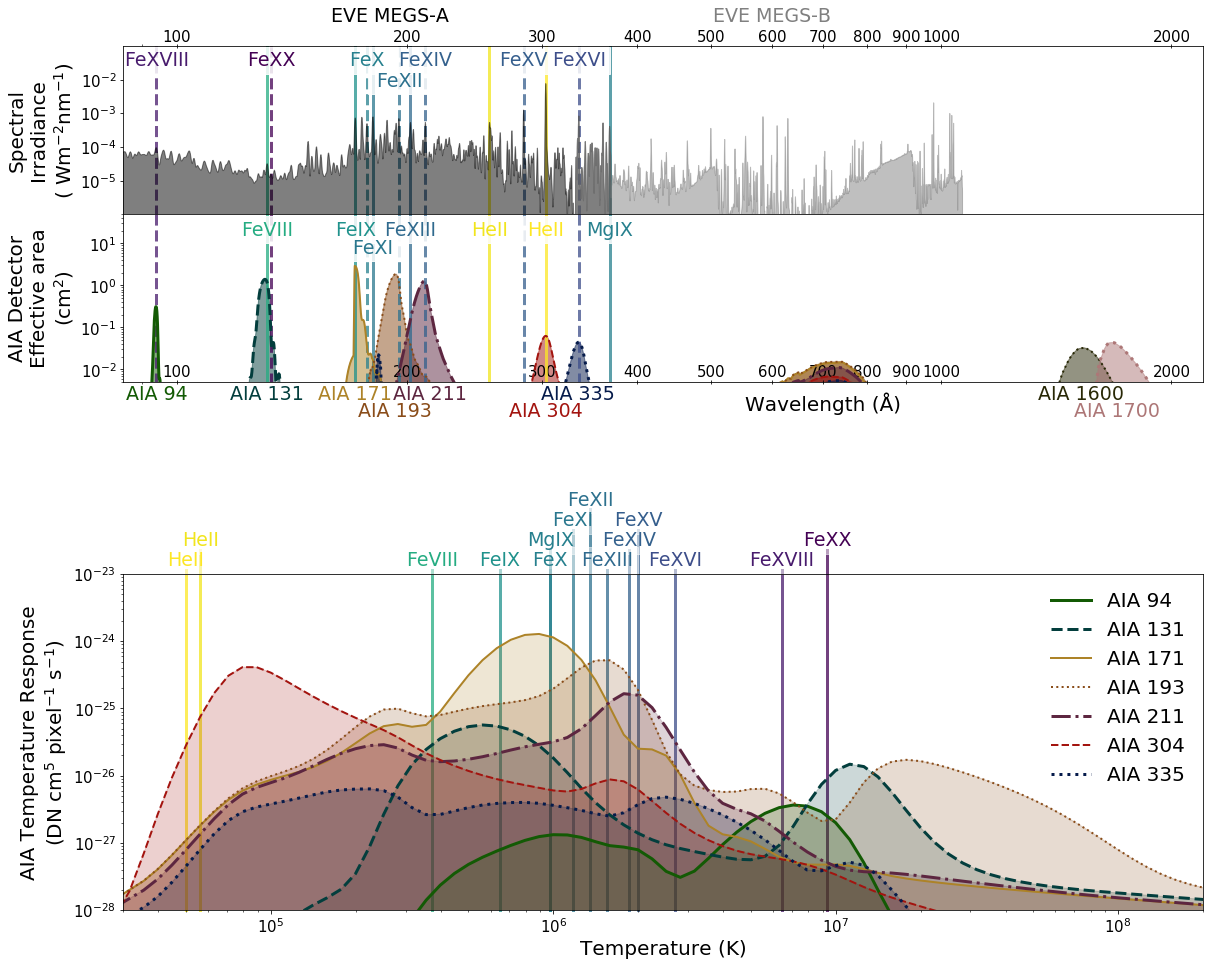

In [4]:
plt.rc('font', **font)

# Size definitions
dpi = 300
pxx = 4500   # Horizontal size of each panel
pxy = 700    # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 2      # Number of vertical panels

# Padding
padv  = 200 #Vertical padding in pixels
padv2 = 800  #Vertical padding in pixels between panels
padh  = 300 #Horizontal padding in pixels at the edge of the figure
padh2 = 150 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in pixels
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in pixels

# Conversion to relative unites
ppxx   = pxx/fszh
ppxy   = pxy/fszv
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszh     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszh    #Horizontal padding between panels in relative units


## Start Figure

fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

y1 = 1e-6
y2 = 1e-1

l1 = 85
l2 = 2200

alphUn = 0.5
FZ = 19
bboxD = {'color':'w', 'alpha': 0.85}
txtF = 1.3


ax2 = fig.add_axes([ppadh, ppadv+3*ppxy+ppadv2, ppxx, ppxy])

norm = matplotlib.colors.LogNorm(vmin=np.power(10,np.min(logT)), vmax=np.power(10,np.max(logT)))
cmap = matplotlib.cm.get_cmap('viridis_r')

Tin = np.argsort(logT)

for i in range(wl.shape[0]):
    
    txty = y2;
    txty=txty/1.4
    clr = cmap(norm(np.power(10,logT[i])))
    txt = EVE_order[i].strip().replace(" ", "")
    loc = 'top'
    if i%2==1:
#         clr = 'r'
        ax2.plot([wl[i],wl[i]],[y2,y1],color=clr,alpha=0.75,linestyle='-',linewidth=3, zorder=0)
    else:
        if i==6:
            txty = txty/4
        ax2.text( wl[i], txty,'         ', va=loc, ha='center',color=clr, fontsize=FZ, bbox = bboxD, zorder=1)
        ax2.plot([wl[i],wl[i]],[y2,y1],color=clr,alpha=0.75,linestyle='--',linewidth=3, zorder=0)
        ax2.text( wl[i], txty, txt, va=loc, ha='center',color=clr, fontsize=FZ, zorder=4)



x = hdul[1].data.field(0)
y = np.squeeze(hdul[6].data.field(4))

x = x[y>0]
y = y[y>0]

xA = x[x<37]
yA = y[x<37]

xB = x[x>33]
yB = y[x>33]

ax2.fill_between(xA*10,yA*0,yA, alpha = 0.5, color=ClrAIA[9], zorder=3)
ax2.text(190, y2*4, 'EVE MEGS-A', va='bottom', ha='center',color=ClrAIA[9], fontsize=FZ)



ax2.fill_between(xB*10,yB*0,yB, alpha = 0.5, color=ClrAIA[10], zorder=3)
ax2.text(600, y2*4, 'EVE MEGS-B', va='bottom', ha='center',color=ClrAIA[10], fontsize=FZ)


ax2.set_ylim(top=y2, bottom=y1)
ax2.set_xlim(left=l1,right=l2)
ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_ylabel('Spectral\nIrradiance\n( Wm$^{-2}$nm$^{-1}$)', size=20)
ax2.set_xticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000])
ax2.set_xticklabels(['100','200', '300','400', '500','600', '700','800', '900','1000', '2000'])

ax2.set_yticks([1e-5, 1e-4, 1e-3, 1e-2])

# ax2.text(700, y2*1.3, 'Wavelength (Å)', va='bottom', ha='center',color='k', fontsize=17)

# ax2.annotate('(a)',xy=(1, 0.99),xycoords='axes fraction',fontsize=30,va='top', ha='right')

ax2.xaxis.tick_top()
ax2.tick_params(axis='x',direction = 'inout', pad=0)



ax1 = fig.add_axes([ppadh, ppadv+2*ppxy+ppadv2, ppxx, ppxy])

y1 = 0.005
y2 = 50


for i in range(wl.shape[0]):
    
    txty = y2;
    clr = cmap(norm(np.power(10,logT[i])))
    txt = EVE_order[i].strip().replace(" ", "")
    loc = 'bottom'
    if i%2==1:
        txty=txty/1.4
        if i==5:
            txty=txty/2.7
            txt = '          '
            
        if i==3:
            txt = '          '
        
#         clr = 'r'
        loc = 'top'
        ax1.text( wl[i], txty, txt, va=loc, ha='center',color=clr, fontsize=FZ, bbox = bboxD)
        ax1.plot([wl[i],wl[i]],[y2,y1],color=clr,alpha=0.75,linestyle='-',linewidth=3)
    else:
        ax1.plot([wl[i],wl[i]],[y2,y1],color=clr,alpha=0.75,linestyle='--',linewidth=3)

        
i = 3 
txty = y2;
txty=txty/1.4
clr = cmap(norm(np.power(10,logT[i])))
txt = EVE_order[i].strip().replace(" ", "")
loc = 'top'
ax1.text( wl[i], txty, txt, va=loc, ha='center',color=clr, fontsize=FZ)
# ax1.plot([wl[i],wl[i]],[y2,y1],color=clr,alpha=0.75,linestyle='-.',linewidth=2)

i = 5
clr = cmap(norm(np.power(10,logT[i])))
txt = EVE_order[i].strip().replace(" ", "")
txty=txty/2.7
ax1.text( wl[i], txty, txt, va=loc, ha='center',color=clr, fontsize=FZ)


txtdiv = 1.15
# plt.plot(b['A94_FULL']['WAVE'],b['A94_FULL']['EFFAREA'],label='AIA 94')
ax1.fill_between(b['A94_FULL']['WAVE'],b['A94_FULL']['EFFAREA']*0, b['A94_FULL']['EFFAREA'],color=ClrAIA[0], edgecolor='none',alpha=alphUn, label='AIA 94')
ax1.text( 94, y1/txtdiv, 'AIA 94', va='top', ha='center',color=ClrAIA[0], fontsize=FZ)


# plt.plot(b['A131_FULL']['WAVE'],b['A131_FULL']['EFFAREA'],label='AIA 131')
ax1.fill_between(b['A131_FULL']['WAVE'],b['A131_FULL']['EFFAREA']*0, b['A131_FULL']['EFFAREA'],color=ClrAIA[1], edgecolor='none',alpha=alphUn, label='AIA 131')
ax1.text( 131, y1/txtdiv, 'AIA 131', va='top', ha='center',color=ClrAIA[1], fontsize=FZ)


# plt.plot(b['A171_FULL']['WAVE'],b['A171_FULL']['EFFAREA'],label='AIA 171')
ax1.fill_between(b['A171_FULL']['WAVE'],b['A171_FULL']['EFFAREA']*0, b['A171_FULL']['EFFAREA'],color=ClrAIA[2], edgecolor='none',alpha=alphUn, label='AIA 171')
ax1.text( 171, y1/txtdiv, 'AIA 171', va='top', ha='center',color=ClrAIA[2], fontsize=FZ)

# plt.plot(b['A193_FULL']['WAVE'],b['A193_FULL']['EFFAREA'],label='AIA 193')
ax1.fill_between(b['A193_FULL']['WAVE'],b['A193_FULL']['EFFAREA']*0, b['A193_FULL']['EFFAREA'],color=ClrAIA[3], edgecolor='none',alpha=alphUn, label='AIA 193')
ax1.text( 193, y1/txtdiv/2.5, 'AIA 193', va='top', ha='center',color=ClrAIA[3], fontsize=FZ)

# plt.plot(b['A211_FULL']['WAVE'],b['A211_FULL']['EFFAREA'],label='AIA 211')
ax1.fill_between(b['A211_FULL']['WAVE'],b['A211_FULL']['EFFAREA']*0, b['A211_FULL']['EFFAREA'],color=ClrAIA[4], edgecolor='none',alpha=alphUn, label='AIA 211')
ax1.text( 211+3, y1/txtdiv, 'AIA 211', va='top', ha='center',color=ClrAIA[4], fontsize=FZ)

# plt.plot(b['A304_FULL']['WAVE'],b['A304_FULL']['EFFAREA'],label='AIA 304')
ax1.fill_between(b['A304_FULL']['WAVE'],b['A304_FULL']['EFFAREA']*0, b['A304_FULL']['EFFAREA'],color=ClrAIA[5], edgecolor='none',alpha=alphUn, label='AIA 304')
ax1.text( 304, y1/txtdiv/2.5, 'AIA 304', va='top', ha='center',color=ClrAIA[5], fontsize=FZ)

# plt.plot(b['A335_FULL']['WAVE'],b['A335_FULL']['EFFAREA'],label='AIA 335')
ax1.fill_between(b['A335_FULL']['WAVE'],b['A335_FULL']['EFFAREA']*0, b['A335_FULL']['EFFAREA'],color=ClrAIA[6], edgecolor='none',alpha=alphUn, label='AIA 335')
ax1.text( 335, y1/txtdiv, 'AIA 335', va='top', ha='center',color=ClrAIA[6], fontsize=FZ)

ax1.fill_between(bb['A1600_FULL']['WAVE'],bb['A1600_FULL']['EFFAREA']*0, bb['A1600_FULL']['EFFAREA'],color=ClrAIA[7], edgecolor='none',alpha=alphUn, label='AIA 1600')
ax1.text( 1525, y1/txtdiv, 'AIA 1600', va='top', ha='center',color=ClrAIA[7], fontsize=FZ)

ax1.fill_between(bb['A1700_FULL']['WAVE'],bb['A1700_FULL']['EFFAREA']*0, bb['A1700_FULL']['EFFAREA'],color=ClrAIA[8], edgecolor='none',alpha=alphUn, label='AIA 1700')
ax1.text( 1700, y1/txtdiv/2.5, 'AIA 1700', va='top', ha='center',color=ClrAIA[8], fontsize=FZ)


ax1.text(700, y1/txtdiv/1.5, 'Wavelength (Å)', va='top', ha='center',color='k', fontsize=20)

lw = 2

ax1.plot(b['A94_FULL']['WAVE'],b['A94_FULL']['EFFAREA'], color = ClrAIA[0],label='AIA 94', linewidth = 3)
ax1.plot(b['A131_FULL']['WAVE'],b['A131_FULL']['EFFAREA'], color = ClrAIA[1],label='AIA 131', linewidth = 3, linestyle = '--')
ax1.plot(b['A171_FULL']['WAVE'],b['A171_FULL']['EFFAREA'], color = ClrAIA[2],label='AIA 171', linewidth = lw)
ax1.plot(b['A193_FULL']['WAVE'],b['A193_FULL']['EFFAREA'], color = ClrAIA[3],label='AIA 193', linewidth = lw, linestyle = ':')
ax1.plot(b['A211_FULL']['WAVE'],b['A211_FULL']['EFFAREA'], color = ClrAIA[4],label='AIA 211', linewidth = 3, linestyle = '-.')
ax1.plot(b['A304_FULL']['WAVE'],b['A304_FULL']['EFFAREA'], color = ClrAIA[5],label='AIA 304', linewidth = lw, linestyle = '--')
ax1.plot(b['A335_FULL']['WAVE'],b['A335_FULL']['EFFAREA'], color = ClrAIA[6],label='AIA 335', linewidth = 3, linestyle = ':')
ax1.plot(bb['A1600_FULL']['WAVE'],bb['A1600_FULL']['EFFAREA'], color = ClrAIA[7],label='AIA 335', linewidth = 2, linestyle = ':')
ax1.plot(bb['A1700_FULL']['WAVE'],bb['A1700_FULL']['EFFAREA'], color = ClrAIA[8],label='AIA 335', linewidth = 3, linestyle = ':')





ax1.set_ylim(top=y2, bottom=y1)
ax1.set_xlim(left=l1,right=l2)
ax1.set_yscale("log")
ax1.set_xscale("log")
# ax1.set_xlabel('Wavelength (Å)', size=20)
ax1.set_ylabel('AIA Detector\nEffective area\n(cm$^2$)', size=20)
ax1.set_xticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000])
ax1.set_xticklabels(['100','200', '300','400', '500','600', '700','800', '900','1000', '2000'])
ax1.tick_params(axis='x',direction = 'inout', pad=-19)
# ax1.annotate('(b)',xy=(1, 0.99),xycoords='axes fraction',fontsize=30,va='top', ha='right')



y1 = 1e-28
y2 = 1e-23

bboxD = {'color':'w', 'alpha': 0.5}

ax3 = fig.add_axes([ppadh, ppadv, ppxx, 2*ppxy])

alphUn = 0.2

ax3.fill_between(np.power(10,a['A131']['LOGTE']),a['A131']['TRESP']*0, a['A131']['TRESP'],color=ClrAIA[1], edgecolor='none',alpha=alphUn)
ax3.fill_between(np.power(10,a['A171']['LOGTE']),a['A171']['TRESP']*0, a['A171']['TRESP'],color=ClrAIA[2], edgecolor='none',alpha=alphUn)
ax3.fill_between(np.power(10,a['A193']['LOGTE']),a['A193']['TRESP']*0, a['A193']['TRESP'],color=ClrAIA[3], edgecolor='none',alpha=alphUn)
ax3.fill_between(np.power(10,a['A211']['LOGTE']),a['A211']['TRESP']*0, a['A211']['TRESP'],color=ClrAIA[4], edgecolor='none',alpha=alphUn)
ax3.fill_between(np.power(10,a['A304']['LOGTE']),a['A304']['TRESP']*0, a['A304']['TRESP'],color=ClrAIA[5], edgecolor='none',alpha=alphUn)
ax3.fill_between(np.power(10,a['A335']['LOGTE']),a['A335']['TRESP']*0, a['A335']['TRESP'],color=ClrAIA[6], edgecolor='none',alpha=alphUn)
ax3.fill_between(np.power(10,a['A94']['LOGTE']),a['A94']['TRESP']*0, a['A94']['TRESP'],color=ClrAIA[0], edgecolor='none',alpha=alphUn)



ax3.plot(np.power(10,a['A94']['LOGTE']),a['A94']['TRESP'], color = ClrAIA[0],label='AIA 94', linewidth = 3)
ax3.plot(np.power(10,a['A131']['LOGTE']),a['A131']['TRESP'], color = ClrAIA[1],label='AIA 131', linewidth = 3, linestyle = '--')
ax3.plot(np.power(10,a['A171']['LOGTE']),a['A171']['TRESP'], color = ClrAIA[2],label='AIA 171', linewidth = lw)
ax3.plot(np.power(10,a['A193']['LOGTE']),a['A193']['TRESP'], color = ClrAIA[3],label='AIA 193', linewidth = lw, linestyle = ':')
ax3.plot(np.power(10,a['A211']['LOGTE']),a['A211']['TRESP'], color = ClrAIA[4],label='AIA 211', linewidth = 3, linestyle = '-.')
ax3.plot(np.power(10,a['A304']['LOGTE']),a['A304']['TRESP'], color = ClrAIA[5],label='AIA 304', linewidth = lw, linestyle = '--')
ax3.plot(np.power(10,a['A335']['LOGTE']),a['A335']['TRESP'], color = ClrAIA[6],label='AIA 335', linewidth = 3, linestyle = ':')



for i in range(wl.shape[0]):
    
    txty = y2*1.15;
    clr = 'k'
    txt = EVE_order[Tin[i]].strip().replace(" ", "")
    loc = 'bottom'
    ls = '-'
#     if i%2==1:
#         ls = '--'
#     if i%3==2:
#         ls = ':'
    if i==1 or i==5 or i==9 or i==13:
        txty = txty*2

    if i==6 or i==10:
        txty = txty*4
        
    if i==7:
        txty = txty*8
        

    ax3.text( np.power(10,logT[Tin[i]]), txty,'         ', va=loc, ha='center',color=clr, fontsize=FZ, bbox = bboxD, zorder=1)    
    ax3.text( np.power(10,logT[Tin[i]]), txty, txt, va=loc, ha='center',color=cmap(norm(np.power(10,logT[Tin[i]]))), fontsize=FZ)
    ax3.plot([np.power(10,logT[Tin[i]]),np.power(10,logT[Tin[i]])],[txty,y1],color=cmap(norm(np.power(10,logT[Tin[i]]))),alpha=0.75,linestyle=ls,linewidth=3, clip_on = False, zorder = 0)


ax3.set_ylim(top=y2, bottom=y1)
ax3.set_xlim(left=3e4,right=2e8)
ax3.set_yscale("log")
ax3.set_xscale("log")
ax3.set_xlabel('Temperature (K)', size=20)
ax3.set_ylabel('AIA Temperature Response\n(DN cm$^5$ pixel$^{-1}$ s$^{-1}$)', size=20)
# ax1.set_ylabel('Effective area\n(cm$^2$)', size=20)
# ax1.set_xticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000])
# ax1.set_xticklabels(['100','200', '300','400', '500','600', '700','800', '900','1000', '2000'])
# ax1.tick_params(axis='x',direction = 'inout', pad=-19)

ax3.legend(edgecolor = 'none',fontsize = 20)
# ax3.annotate('(c)',xy=(0, 0.99),xycoords='axes fraction',fontsize=30,va='top', ha='left')

# ax1.legend()
fig.savefig('AIA_Spectral_response.png',dpi=figDPI, bbox_inches='tight')